#PHYS 481 Assignment 1
September 9, 2019

## Authors: 
Siegfried Peschke (30032136) \\
Matthew Bouchard (30003689) \\
Chris Godek (30030527)






## Import Necessary Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

##Problem 1: True Riffle Shuffle

Write a Python function to perform a real shuffle. Don't employ any randomness; rather, criterion. Applying such a function five or six times should leave a deck almost indistinguishable from truly randomly ordered.

Let us walk through the algorithm that will be executed to solve this problem.
* Split the deck, specifying the 'error' or deviation from half. \\
The larger subdeck will be called deck 1 and the smaller subdeck will be called deck 2
* Calculate the ratio of cards between the two decks by dividing the deck 2 from deck 1. \\
Round this ratio to the nearest decimal, then multiply by 10 and cast this number to an integer.
* We take deck 1 and multiply its size by 10 as well. \\
This allows us to insert deck 2 using a 'false' 1 decimal place precision.
* Now we iterate through deck 1 using the ratio we calculated in step 2. At each iteration, we insert a card from the front of deck 2. \\
Note: Because of rounding in the ratio, it is possible to iterate over the 'end' of the deck. Therefore any remaining cards, which should only be 1, will go to the end of the mixed deck.
* Now take the mixed deck and divide its size by 10. \\
The deck is now mixed!

In [0]:
def riffle_shuffle(deck, error):
  #Split the deck roughly into half (+/- 10 cards)
  subdeck1 = deck[0:26+error]
  subdeck2 = deck[26+error:52]
  
  #Now have 2 lists, take the ratio and multiply by 10
  deck_ratio = int((round(len(subdeck1) / len(subdeck2), 1)) * 10)
  
  #Take subdeck1, and multiply its size by 10
  #Do this by adding 9 '?' before every 'card'
  mixed_deck = subdeck1
  for s in range(len(mixed_deck)):
    for t in range(9):
      mixed_deck.insert(s*10, '?')
  
  #Insert subdeck2 going by the ratio
  #Add any remaining cards to the end of the deck
  location = 0
  for i in range(len(subdeck2)):
    if (location + deck_ratio) < len(subdeck1)*10:
      location += deck_ratio
      mixed_deck.insert(location, subdeck2[i])
    else:
      mixed_deck.append(subdeck2[i])
  
  #Remove all the '?'
  deletednum = 0
  for u in range(len(mixed_deck)):
    if mixed_deck[u - deletednum] == '?':
      del mixed_deck[u - deletednum]
      deletednum += 1
      
  #Return the mixed deck    
  return(mixed_deck) 

In [0]:
deck = list(range(1, 53)) #Generate a deck numbered 1-52
print(riffle_shuffle(deck, 8)) #Mix the deck with a size difference of 16 between 'halves'

[1, 35, 2, 3, 36, 4, 5, 37, 6, 7, 38, 8, 9, 39, 10, 40, 11, 12, 41, 13, 14, 42, 15, 16, 43, 17, 18, 44, 19, 45, 20, 21, 46, 22, 23, 47, 24, 25, 48, 26, 27, 49, 28, 50, 29, 30, 51, 31, 32, 52, 33, 34]


##Problem 2: Generalizing Arnolds Map

Suppose that Arnold's map was 

$x_{t+1}=p x_t+q y_t\;{\rm mod}\; N;\quad y_{t+1}=r x_t+s y_t\;{\rm mod}\; N,$ where $p,q,r,s\in\mathbb{Z}$.

We can describe the $x$ and $y$ values of the pixel as a two-dimensional vector, and the action of the cat map as a matrix operating on this vector:
\begin{equation}
\begin{pmatrix}
x\cr y\cr
\end{pmatrix}_{t+1}
=\begin{pmatrix}
p & q\cr r & s\cr
\end{pmatrix}
\begin{pmatrix}
x\cr y\cr
\end{pmatrix}_t\;\mbox{mod}\;N.
\end{equation}
Thus, the values after $n$ steps are given by 
\begin{equation}
\begin{pmatrix}
x\cr y\cr
\end{pmatrix}_{t+n}
=\begin{pmatrix}
p & q\cr r & s\cr
\end{pmatrix}^n
\begin{pmatrix}
x\cr y\cr
\end{pmatrix}_t\;\mbox{mod}\;N.
\end{equation}
Find $n$ such that 
\begin{equation}
\begin{pmatrix}
p & q\cr r & s\cr
\end{pmatrix}^n\;\mbox{mod}\;N=I\quad\leftrightarrow\quad M^n\;\mbox{mod}\;N=I,
\end{equation}
where $I$ is the identity and $M$ is the matrix of interest.

Write a routine to effect $n$ successive multiplications of $M$ with itself, to see if there is a value of $n$ that returns the identity matrix. If requested many more than 350 shuffles, would the results be any different?

Assuming that $p,q,r,s\in\{1,2\}$ (i.e. 16 combinations), determine the number of timesteps required to restore the cat image.

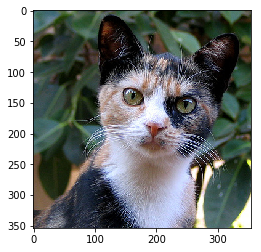

In [0]:
#Import Arnolds Cat from the notes
#Use the python imaging library (PIL) package to read an image from a network URL.
image_url = "https://www.jasondavies.com/catmap/catmap.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

#Turn the PIL image into a numpy array.
data = np.array(img)
plt.imshow(data)

In [0]:
#Modifying the given catmap1 function from the notes
def catmap(square, p, q, r, s):
# Apply Arnold's cat map to a square NxN numpy array
# using loops to modify pixels one at a time.

  nx,ny = square.shape[0:2]
  assert (nx == ny & ny > 1)
  result = square.copy()
  for x in range(nx):
    for y in range(ny):
      xx = p*x + q*y
      yy = r*x + s*y
      result[x,y] = square[xx % nx, yy % ny]
    
  return result

In order to generalize Arnolds map, we will create 2 functions. The first will carry out the mathematical operation $A\:B\;\mbox{mod}\;N$ where A and B are matrices and N is an integer. The second function will carry out the task of finding an n value such that $M^n\;\mbox{mod}\;N=I$. It will utilize the first function in repition with every increase in n and then compare the result to the identity matrix until either the identity matrix is found or $3N$ iterations are reached.

In [0]:
def matrix_multiply_modulo(A, B, N):
  #Matrix multiply A and B (A*B)
  multiplied = np.matrix.tolist(np.matrix(A) * np.matrix(B))
  
  #Take the modulo of the matrix
  row1 = []
  row2 = []
  for i in range(2):
    for j in range(2):
      val = (multiplied[i][j]) % N
      if i == 0:
        row1.append(val)
      else:
        row2.append(val)
      result = [row1, row2]
  
  return result

def find_n(X, N):
  I = [[1,0],[0,1]] #The identity matrix
  n = 1
  Y = matrix_multiply_modulo(X, X, N) #Perform n = 1
  while Y != I:
    if n > 3*N:
      print('\t 3N iterations reached')
      return
    Y = matrix_multiply_modulo(X, Y, N) #Y = M^n
    n += 1
  print('\t Exponent required to reach the identity matrix is n =', n)
  return n

Now that the functions have been created, we will test all 16 combinations of $p,q,r,s\in\{1,2\}$ and display the results.

In [0]:
N = 354
for p in range(1,3):
  for q in range(1,3):
    for r in range(1,3):
      for s in range(1,3):
        print('p =', p, 'q =', q, 'r =', r, 's =', s)
        X = [[p,q],[r,s]]
        find_n(X, N)

p = 1 q = 1 r = 1 s = 1
	 3N iterations reached
p = 1 q = 1 r = 1 s = 2
	 Exponent required to reach the identity matrix is n = 347
p = 1 q = 1 r = 2 s = 1
	 Exponent required to reach the identity matrix is n = 39
p = 1 q = 1 r = 2 s = 2
	 3N iterations reached
p = 1 q = 2 r = 1 s = 1
	 Exponent required to reach the identity matrix is n = 39
p = 1 q = 2 r = 1 s = 2
	 3N iterations reached
p = 1 q = 2 r = 2 s = 1
	 3N iterations reached
p = 1 q = 2 r = 2 s = 2
	 3N iterations reached
p = 2 q = 1 r = 1 s = 1
	 Exponent required to reach the identity matrix is n = 347
p = 2 q = 1 r = 1 s = 2
	 3N iterations reached
p = 2 q = 1 r = 2 s = 1
	 3N iterations reached
p = 2 q = 1 r = 2 s = 2
	 3N iterations reached
p = 2 q = 2 r = 1 s = 1
	 3N iterations reached
p = 2 q = 2 r = 1 s = 2
	 3N iterations reached
p = 2 q = 2 r = 2 s = 1
	 3N iterations reached
p = 2 q = 2 r = 2 s = 2
	 3N iterations reached


Therefore we find that
\begin{equation}
M =\begin{pmatrix} 1 & 1\cr 1 & 2 \end{pmatrix}\: \textrm{requires}\: n = 347\\ 
M =\begin{pmatrix} 1 & 1\cr 2 & 1 \end{pmatrix}\: \textrm{requires}\: n = 39\\
M =\begin{pmatrix} 1 & 2\cr 1 & 1 \end{pmatrix}\: \textrm{requires}\: n = 39\\
M =\begin{pmatrix} 2 & 1\cr 1 & 1 \end{pmatrix}\: \textrm{requires}\: n = 347\\
\end{equation}
to return the image to its original state. The data suggests that the rest of the combinations do not return to the original state. \\

Now we will show each of these 4 combinations after n shufflings of the image.

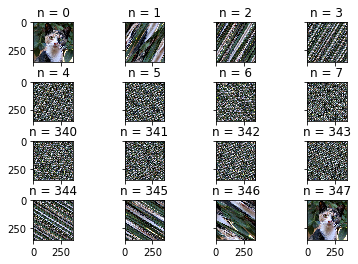

In [0]:
#Show the results for successive applications of the cat map
p, q, r, s = 1, 1, 1, 2

newdat = np.array(img)
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
offset = 0
for i in range(4):
  if i == 2:
    for offset in range(347-14):
      newdat = catmap(newdat, p, q, r, s)
  for j in range(4):
    axes[i,j].imshow(newdat)
    newdat = catmap(newdat, p, q, r, s)
    axes[i,j].set_title('n = ' + str(i*4 + j + offset))

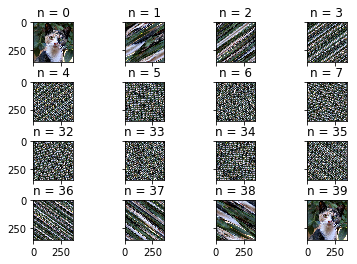

In [0]:
#Show the results for successive applications of the cat map
p, q, r, s = 1, 1, 2, 1

newdat = np.array(img)
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
offset = 0
for i in range(4):
  if i == 2:
    for offset in range(39-14):
      newdat = catmap(newdat, p, q, r, s)
  for j in range(4):
    axes[i,j].imshow(newdat)
    newdat = catmap(newdat, p, q, r, s)
    axes[i,j].set_title('n = ' + str(i*4 + j + offset))

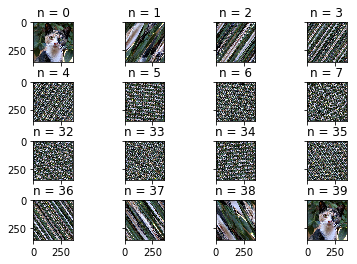

In [0]:
#Show the results for successive applications of the cat map
p, q, r, s = 1, 2, 1, 1

newdat = np.array(img)
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
offset = 0
for i in range(4):
  if i == 2:
    for offset in range(39-14):
      newdat = catmap(newdat, p, q, r, s)
  for j in range(4):
    axes[i,j].imshow(newdat)
    newdat = catmap(newdat, p, q, r, s)
    axes[i,j].set_title('n = ' + str(i*4 + j + offset))

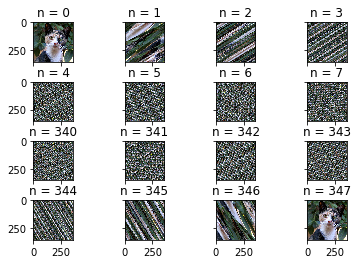

In [0]:
#Show the results for successive applications of the cat map
p, q, r, s = 2, 1, 1, 1

newdat = np.array(img)
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
offset = 0
for i in range(4):
  if i == 2:
    for offset in range(347-14):
      newdat = catmap(newdat, p, q, r, s)
  for j in range(4):
    axes[i,j].imshow(newdat)
    newdat = catmap(newdat, p, q, r, s)
    axes[i,j].set_title('n = ' + str(i*4 + j + offset))

##Problem 3: Order Finding

In modular exponentiation, one determines $a^r$ (mod $N$), where $a,r,N\in\mathbb{N}$ (i.e. natural numbers). The **order** of $a$ is the smallest positive integer $r$ such that $a^r=1$ (mod $N$). 

The purpose of this question is to find the order of $a$ for $2\leq a\leq 10$ for $1\leq N\leq 1000$. To start, let us define a function that will do exactly that:

In [0]:
def r_hunter(a,output): 
  
  """
  
  -- General Description --
  
  This function aims to solve for the value of r that satisfies the following expression: a^(r) % N = 1 % N.
  The value of r will be calculated for each specified 'a' value and for a value of N from 1 to 1000.
  
  -- How It Works --
  
  This function works by first taking a value of 'a', say 2. For the value of 'a' the function will
  then take a value of N, starting from 1 and moving all the way to 1000. For each value of N an 
  r or order value will be determined. This may be done for multiple 'a' values.
  
  -- Parameters --
  
  a = The value(s) of a for which you want to determine r
  output = The data that you would like the function to output. 1 = lists of r values for each 'a'
  2 = lists of N values for each 'a'
  
  """
  
  
  # --- Stored Values ---
  r_values = []    
  N_values = []
  
  
  # --- Determining the Order of a ---
  for N in range (1,1001): # Running through 1-1000 values of N for each a
    r = 1
    while r < 1000: # Checking all values of r from 1-1000 to find the lowest value
      LHS = a**r % N
      RHS = 1 % N
      if LHS == RHS:
        r_values.append(r)
        N_values.append(N)
        r = 1000 # Terminating the sequence when r is found and moving to next N value
        
      else: # If a value cannot be found the function will attempt the next successive r
          r += 1
  
  # --- Output Options ---
  if output == 1:
    return r_values
  if output == 2:
    return N_values

Now that we have defined a function that will determine the value of r needed to satisfy the expression, we can now plot $r(N)$ and test how $r(N)$ scales with $N$. The process of doing this has been outlined below.

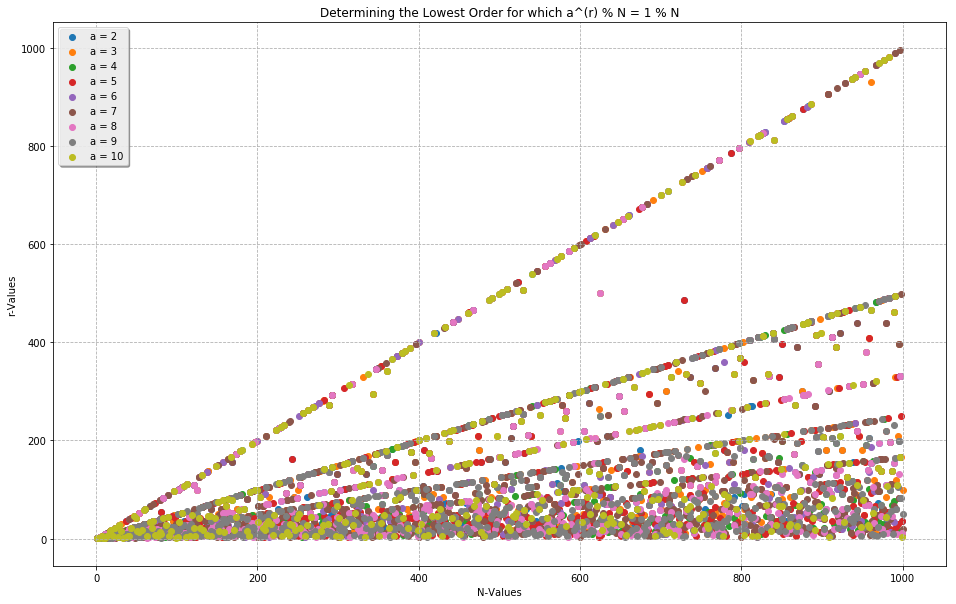

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))

plt.xlabel('N-Values')
plt.ylabel('r-Values')
plt.title('Determining the Lowest Order for which a^(r) % N = 1 % N')
plt.grid(linestyle='dashed')

# Plotting the Function
for a in range(2,11): # Running through all values of a for which we would like to calculate r
  legend_inputs = 'a = ' + str( a )
  plt.scatter( r_hunter(a,2) , r_hunter(a,1) , label = legend_inputs ) # Plotting values of N against r in a scatter plot
  
# Legend Settings
legend = plt.legend( loc = 2 , shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

From the plot we see a few obvious trend lines. These trend lines are linear and seem to have slopes, $m = 1$, $m = \frac{1}{2}$, $m = \frac{1}{3}$, and $m = \frac{1}{4}$. After these 4 trend lines, there are too many 'free' points to discern any other trend lines. This indeed is a conspicuous pattern!



## Problem 4: Integer Factorization

If we want to find a factor for a positive integer, say $N$, then we can follow a series of pre-defined steps. In general, the process goes as follows:

1. Check if $N$ is even; if so, then 2 is a factor. This won't even matter for the most part as we are only checking odd values.

2.  Check if $N$ is a power $a^b$ for integers $a$ and $b$; an
efficient algorithm for this is described by the following: If $N=a^b$, then calculate $N^{1/b}$ for all (integer) $b$ in the range $2\leq b\leq\log N$. If the result is an integer (to within some tolerance), then you're done.

3. For some random $a$, $2<a<N-2$, calculate the greatest common divisor of $a$ and $N$ using Euclid's algorithm; if you find one, this is the answer;

4.  For some random $a$, $2<a<N-2$, solve for the $r$ that solves $a^r=1$ (mod $N$);

5.  If $r$ is odd, go back and choose another value of $a$;

6. If $r$ is even, calculate $a^{r/2}$ mod $N$; if the result is -1 (or $N-1$ mod $N$), then choose another value of $a$;

7.  Otherwise, calculate the greatest common divisor of $a^{r/2}\pm 1$ and $N$; if one of these gives a nontrivial factor, this is the answer;

8. If you still have nothing, choose another value of $a$, and go back to step 3.


For us to calculate a nontrivial factor for each odd $N$ in the range $99900\leq N\leq 100000$ we must start by writing a few functions. The first two functions that we will walk through will be used in the final master function called "Non_Trivial_Factor_Finder". The purpose of seperating the functions is to create an ease of reading for you, the marker. 

The first function we will cover is the GCD_Finder. The purpose of this function is to determine the greatest common divisor, for some values a and b. This function will work by following Euclid's algorithm, which is explained in the doc string of the function. This will be used to satisfy statement 3. It may also be used multiple times if our randomly chosen "a" does not return a non-trivial factor.

---



In [0]:
def GCD_Finder(a,b):
  
  """
  
  --- General Description ---

  The purpose of this function is to determine the greatest common divisor (or GCD) between two values; a and b. The greatest common divisor is the largest value that
  can return an integer value when divided by either a or b. 

  --- How It Works ---

  This function works by following Euclid's algorithm for determining a GCD between two values a and b. This process has been outlined below:

  Step 1: If a<b, exchange a and b. This is a check in case the user has placed the values in the incorrect position. We will assume a>b in this function.
  Step 2: Divide a by b and get the remainder, r. This can be computed via the modulo, %. If r=0 (i.e a% b ==0), report b as the GCD of a and b.
  Step 3: Replace a by b and replace b by r. This kicks out the lowest Return to the previous step.

  --- Parameters ---

  a = Some value you wish to determine a GCD for when compared with value b (typically place your larger value here, but it is OK if you do not, redundancies have been built in)
  b = The second value for which you wish to determine a GCD when compared with value a (typically place your smaller value here, but it is OK if you do not)
  
  """
  
  # --- Making Sure Larger Value is in Numerator ---
  if b > a: # We assume 'a' is larger, but we must account in case b>a
    return GCD_Finder( b , a ) #This will call the original function, but with 
                           # the greater value 'b' in the 'a' position. The 
                           # smaller 'a' value will be in the b position as 
                           # intended.
    
  
  # --- Checking of a%b == 0 ---
  if a % b == 0: 
    return b
  
  # --- Divising a/b and swapping factors ---
  return GCD_Finder(b, a % b) # Swapping factors to continue along the Euclidean algorithm 

This section function "Single_r_Hunter" is used to satisfy the requirements of step 4. It would be possible to re-use the function in question 3, however, we are only required to find a single value of r because we are only given a single a value. Thereby, there is no need for lists or multiple computations. So this function strips "r_hunter" from question 3 to its bare bones.

In [0]:
def Single_r_Hunter(a,N):
   
    """

    --- General Description ---

    This function aims to solve for a value of r that will satisfy the following expression: a^(r) % N = 1 % N. 

    --- How It Works ---

    This function will start with an r value of 1. It will they attempt to see if that particular value solves the expression outlined in the general description.
    If the expression is NOT satisfied, the function will then try and r value of 2. It will then continue this pattern of trying sucessive r values (in increments of 1)
    until it finds a value that solves the expression. It will do this 100 times before quitting. This value of 100 was chosen through trial and error.

    --- Parameters ---

    a = The random value for which this equation is trying to be solved
    N = Another value, however, in the context of this question it will be all odd values inbetween 99,000 and 100,000
    
    """
    r = 1
    
    # Finding the value of r that satisfies the a^(r)%N=1%N condition.
    while r < 100:
      LHS = a**r % N
      RHS = 1 % N
      
      if LHS==RHS:
        return r # Returning the given value
        r=100
      else:
        r += 1

In [0]:
def Non_Trivial_Factor_Finder(N):
  
  """
  
  -- General Description ---

  This function is designed to find a non-trival (i.e not = 1) factor for any value of N. If a value cannot be found, it is most likely a prime-number. This will be
  reflected in the output of the function.

  --- How it Works ---

  This function works by following the steps outlined at the beginning of the question. Please refer to that to avoid redundancies. 

  --- Parameters ---

  N = The value for which you would like to discern a non-trival factor (*Note: N must be positive, an integer and > 1)
  
  """
  
  # --- Checking N is Even ---
  if N % 2 == 0: # If our function is even then a non-trivial answer will be 2!
    return 2 
  
  # --- Checking if N^(1/b) ---
  for b in range( 2, int( np.log10(N) ) ):
    value = N**(1/b)
    if np.abs( round(value)-value ) < 0.0001:
      return value    
   
  # --- Finding Greatest Common Divisor of 'a' and 'N' --- 
  run_time = 0
  while run_time < 5000: # The number of a values that will be picked

    a = np.random.randint( 3 , N-2 )
    GCD = GCD_Finder(a,N) # Determining if GCD is present using Euclid's algorithm

    if GCD > 1: # If there is a non-trivial GCD we immediately choose that
      return GCD
  
    r = Single_r_Hunter(a,N)
    if r == int: # Making sure that there is in fact a GCD

      if r % 2 != 0: # If `r` is odd we must choose a new value for a
        break
      else: # If r is even we may continue on
        check_val = a**(r/2) % N
        if check_val == -1 or (N-1) % N: # If check_val is between these values we require a new a
          break 
        else: # If check_val is not -1 or (N-1)%N then we may continue
          GCD_2 = GCD_Finder(N , check_val + 1) # GCD Calculation 2
          GCD_3 = GCD_Finder(N , check_val - 1) # GCD Calculation3
          if GCD_2 > 1: # Non-trivial solution
            return GCD_2
          elif GCD_3 > 1: # Non-trivial solution
            return GCD_3
          else:
            break
    run_time += 1
  return

Now that we have outlined all the necessary functions, let us attempt to answer the question; calculate a nontrivial factor for each odd $N$ in the range $99900\leq N\leq 100000$. 

In [0]:
for N in range( 99901 , 100001 , 2): # Moving through each odd value inbetween 99,000 - 100,000
  factor = Non_Trivial_Factor_Finder(N)
  if factor == None:
    print( N , 'has no nontrivial factors and is therefore prime')
  else:
    print( N , 'has a nontrivial factor of:' , factor )

99901 has no nontrivial factors and is therefore prime
99903 has a nontrivial factor of: 3
99905 has a nontrivial factor of: 5
99907 has no nontrivial factors and is therefore prime
99909 has a nontrivial factor of: 3
99911 has a nontrivial factor of: 7
99913 has a nontrivial factor of: 31
99915 has a nontrivial factor of: 5
99917 has a nontrivial factor of: 41
99919 has a nontrivial factor of: 163
99921 has a nontrivial factor of: 19
99923 has no nontrivial factors and is therefore prime
99925 has a nontrivial factor of: 5
99927 has a nontrivial factor of: 3
99929 has no nontrivial factors and is therefore prime
99931 has a nontrivial factor of: 13
99933 has a nontrivial factor of: 3
99935 has a nontrivial factor of: 11
99937 has a nontrivial factor of: 37
99939 has a nontrivial factor of: 7
99941 has a nontrivial factor of: 139
99943 has a nontrivial factor of: 17
99945 has a nontrivial factor of: 9
99947 has a nontrivial factor of: 89
99949 has a nontrivial factor of: 127
99951 has 